<a href="https://colab.research.google.com/github/natrask/ENM5320/blob/main/Code/TransformerDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This jupyter notebook will show how to construct a simple cross-attention transformer that can be used to construct conditional neural fields.
$$y = F(x|z)$$
Here, $x,y$ are input/output labels and $z$ denotes a conditioning variable which modulates the input/output relationship.

This code can be adopted into your final projects - in general this is drastically easier to train than a standard MLP, in addition to providing support for conditioning (if you want/need that).

Some key aspects:

*   The code consists of a `CrossAttnDecoderLayer` block which can be stacked into $N_{blocks}$ blocks to construct deeper architectures.
*   Transformers are in general very data-hungry, and in scientific settings we will rarely have enough data (consider e.g. GPT trained on Wikipedia, vs the 10 experiments you might be able to do in the lab). To mitigate this, dropout is crucial to regularize and prevent overfitting. The `update_dropout_rate` function can be used to control this. In practice you may want to train with dropout turned on, and then implement a scheduler to ease it off as training progresses.
*   In addition to the architecture, there have been a number of works in the past year (2025) where people have explored approximate second-order optimizer (i.e. automatic differentiation is used to construct approximate Hessians, rather that working with a momentum-adjusted stepsize in gradient descent). This code uses Shampoo, which we use in my group. This requires installing Pytorch's torch-optimizer package which includes "non-standard" optimizers that haven't yet made it into the main torch branch.

The code below shows how to instantiate the model, initialize the shampoo optimizer, and solve a simple regression task. No effort has been made to optimize this (e.g. layers, learning rates, etc) so you may need to fiddle with some parameters to get best performance on your problem.



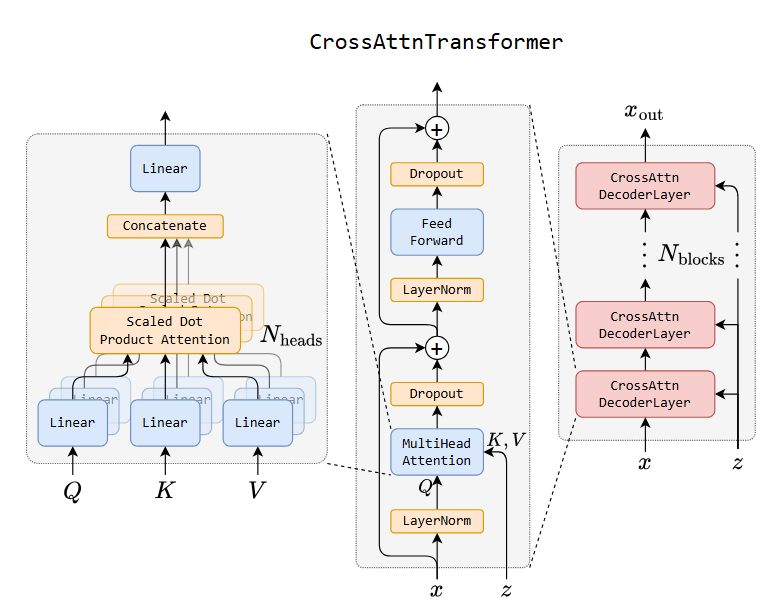

In [ ]:
!pip install torch-optimizer
import numpy as np
import torch
import torch.nn as nn
import torch_optimizer as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Generate the base models for the cross attention decoder block along with an architecture that stacks them together.

In [ ]:
class CrossAttnDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, activation, use_norms):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.use_norms = use_norms

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(d_model * 2, d_model),
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def update_dropout_rate(self, new_rate):
        self.dropout_rate = new_rate

        self.multihead_attn.dropout = new_rate

        for module in self.ffn:
            if isinstance(module, nn.Dropout):
                module.p = new_rate

        self.dropout.p = new_rate

    def forward(self, x, z_embedding):
        # input shapes:
        # x: [batch_size (optional), seq_len (number of x eval points), d_model]
        # z_embedding: [batch_size (optional), d_model]
        # in order to make z_embedding work as a "global" token, we need to add a dummy seq_len dimension of 1
        z_embedding = z_embedding.unsqueeze(-2)  # [batch_size (optional), 1, d_model]
        residual = x
        if self.use_norms:
            x_norm = self.norm1(x)
        else:
            x_norm = x

        attn_output, _ = self.multihead_attn(
            query=x_norm,
            key=z_embedding,
            value=z_embedding,
            need_weights=False,
        )

        x = residual + self.dropout(attn_output)

        residual = x
        if self.use_norms:
            x_norm = self.norm2(x)
        else:
            x_norm = x
        x = residual + self.dropout(self.ffn(x_norm))

        return x


class CrossAttnTransformer(nn.Module):
    def __init__(
        self,
        problem_dim,
        output_dim,
        z_dim,
        num_blocks=3,
        latent_dim=128,
        num_heads=4,
        dropout_rate=0.1,
        activation=nn.GELU(),
        use_norms=True,
    ):
        super().__init__()

        self.problem_dim = problem_dim
        self.output_dim = output_dim
        self.z_dim = z_dim
        self.num_blocks = num_blocks
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.use_norms = use_norms

        self.x_embedding = nn.Linear(self.problem_dim, self.latent_dim)
        self.z_embedding = nn.Linear(self.z_dim, self.latent_dim)

        self.transformer_blocks = nn.ModuleList(
            [
                CrossAttnDecoderLayer(
                    d_model=self.latent_dim,
                    num_heads=num_heads,
                    dropout_rate=dropout_rate,
                    activation=activation,
                    use_norms=use_norms,
                )
                for _ in range(num_blocks)
            ]
        )

        self.final_projection = nn.Linear(self.latent_dim, self.output_dim)

    def update_dropout_rate(self, new_rate):
        self.dropout_rate = new_rate
        for block in self.transformer_blocks:
            block.update_dropout_rate(new_rate)

    def forward(self, x, z):
        x_emb = self.x_embedding(x)
        z_emb = self.z_embedding(z)

        for block in self.transformer_blocks:
            x_emb = block(x_emb, z_emb)

        return self.final_projection(x_emb)

In [ ]:
model = CrossAttnTransformer(
    problem_dim=1,
    output_dim=1,
    z_dim=1,
    num_blocks=3,
    latent_dim=128,
    num_heads=4,
    dropout_rate=0,
    activation=nn.GELU(),
    use_norms=True,
).to(device)

To illustrate how to perform standard regression, we will regress the function
$$y(x|z) = \sin (z\, x),$$
where $$x \in [-\pi,\pi]$$
and $z$ denotes a wavenumber

In [ ]:
# z is going to be the angular frequency from 1 to 5, say
z = torch.linspace(1, 5, 12).unsqueeze(-1)

# x are the evaluation points
x = torch.linspace(-torch.pi, torch.pi, 256)

# y are the target functions, sin(z * x), evaluated at the x points
y = torch.stack([torch.sin(z[i] * x) for i in range(z.shape[0])]).unsqueeze(-1)

# we also build a validation set in between the z values:
z_val = (z[1:] + z[:-1]) / 2.0
y_val = torch.stack([torch.sin(z_val[i] * x) for i in range(z_val.shape[0])]).unsqueeze(
    -1
)

In [ ]:
z_val.shape, y_val.shape
y, z = y.to(device), z.to(device)
train_dataset = torch.utils.data.TensorDataset(z, y)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)

z_val, y_val = z_val.to(device), y_val.to(device)
val_dataset = torch.utils.data.TensorDataset(z_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(z_val), shuffle=False)

x = x.to(device)

In [ ]:
optimizer = optim.Shampoo(
    [
        {
            "params": model.parameters(),
            "lr": 0.01,
            "weight_decay": 0,
            "momentum": 0,
            "update_freq": 1,
        }
    ]
)
# optimizer = torch.optim.Adam(
#     [
#         {
#             "params": model.parameters(),
#             "lr": 1e-5,
#             "weight_decay": 0,
#             "momentum": 0,
#         }
#     ]
# )

In [ ]:
def save(train_loss_history, val_loss_history):
    with open("cross_attn_transformer_test.pkl", "wb") as f:
        pickle.dump(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "train_loss_history": train_loss_history,
                "val_loss_history": val_loss_history,
            },
            f,
        )


def read():
    with open("cross_attn_transformer_test.pkl", "rb") as f:
        data = pickle.load(f)
        model.load_state_dict(data["model"])
        optimizer.load_state_dict(data["optimizer"])
        train_loss_history = data["train_loss_history"]
        val_loss_history = data["val_loss_history"]
    return train_loss_history, val_loss_history

In [ ]:
# read in checkpoint if it exists
try:
    with open("cross_attn_transformer_test.pkl", "rb") as f:
        data = pickle.load(f)
        model.load_state_dict(data["model"])
        optimizer.load_state_dict(data["optimizer"])
        train_loss_history = data["train_loss_history"]
        val_loss_history = data["val_loss_history"]
except FileNotFoundError:
    train_loss_history = []
    val_loss_history = []
    print("No checkpoint found, starting from scratch.")

In [ ]:
time_in_optimizer = 0.0

overall_time_start = time.time()
for epoch in range(0, 1000):
    model.train()
    batch_loss = 0.0
    for i, (z, y) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z.shape[0], -1, -1)

        y_pred = model(x_expanded, z)

        # Compute loss
        loss = nn.functional.mse_loss(y_pred, y)

        batch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        time_start = time.time()
        optimizer.step()
        time_end = time.time()

        time_in_optimizer += time_end - time_start

    batch_loss /= len(train_loader)
    train_loss_history.append(batch_loss)

    # Validation step
    # model.eval()
    with torch.no_grad():
        batch_loss = 0.0
        for z_val, y_val in val_loader:
            x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z_val.shape[0], -1, -1)

            y_val_pred = model(x_expanded, z_val)

            batch_loss += nn.functional.mse_loss(y_val_pred, y_val).item()
        batch_loss /= len(val_loader)

    val_loss_history.append(batch_loss)

    print(
        f"Epoch {epoch}: Train Loss: {train_loss_history[-1]:.4e}, Val Loss: {val_loss_history[-1]:.4e}"
    )

    if epoch % 1000 == 0:
        save(train_loss_history, val_loss_history)
        print("Checkpoint saved.")

overall_time_end = time.time()

frac_in_optimizer = time_in_optimizer / (overall_time_end - overall_time_start)
print(f"Fraction of time in optimizer: {frac_in_optimizer:.6f}")

In [ ]:
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.loglog()

In [ ]:
with torch.no_grad():
    z, y = train_dataset.tensors
    x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z.shape[0], -1, -1)
    y_pred = model(x_expanded, z)

    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(12):
        axs[i // 4, i % 4].plot(x.cpu(), y[i].cpu(), label="True")
        axs[i // 4, i % 4].plot(x.cpu(), y_pred[i].cpu(), label="Predicted")
        axs[i // 4, i % 4].set_title(f"z={z[i].item():.2f}")
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():
    for z_val, y_val in val_loader:
        x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z_val.shape[0], -1, -1)

        y_val_pred = model(x_expanded, z_val)

        fig, axs = plt.subplots(3, 4, figsize=(15, 10))
        for i in range(11):
            axs[i // 4, i % 4].plot(x.cpu(), y_val[i].cpu(), label="True")
            axs[i // 4, i % 4].plot(x.cpu(), y_val_pred[i].cpu(), label="Predicted")
            axs[i // 4, i % 4].set_title(f"z={z_val[i].item():.2f}")
        plt.tight_layout()
        plt.show()